In [1]:
#import user modules
import helper_functions as hfun
import config as cf
import thouless_times as thouless
import plot_spectrals as spec_fun
import adiabatics as agp
import importlib
importlib.reload(hfun)
importlib.reload(cf)
importlib.reload(thouless)
importlib.reload(spec_fun)
importlib.reload(agp)

#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym
from scipy.optimize import curve_fit as fit

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')

../results/Heisenberg/disorder/PBC/


### GAP RATIO AND CHAOTIC STATIDTICS

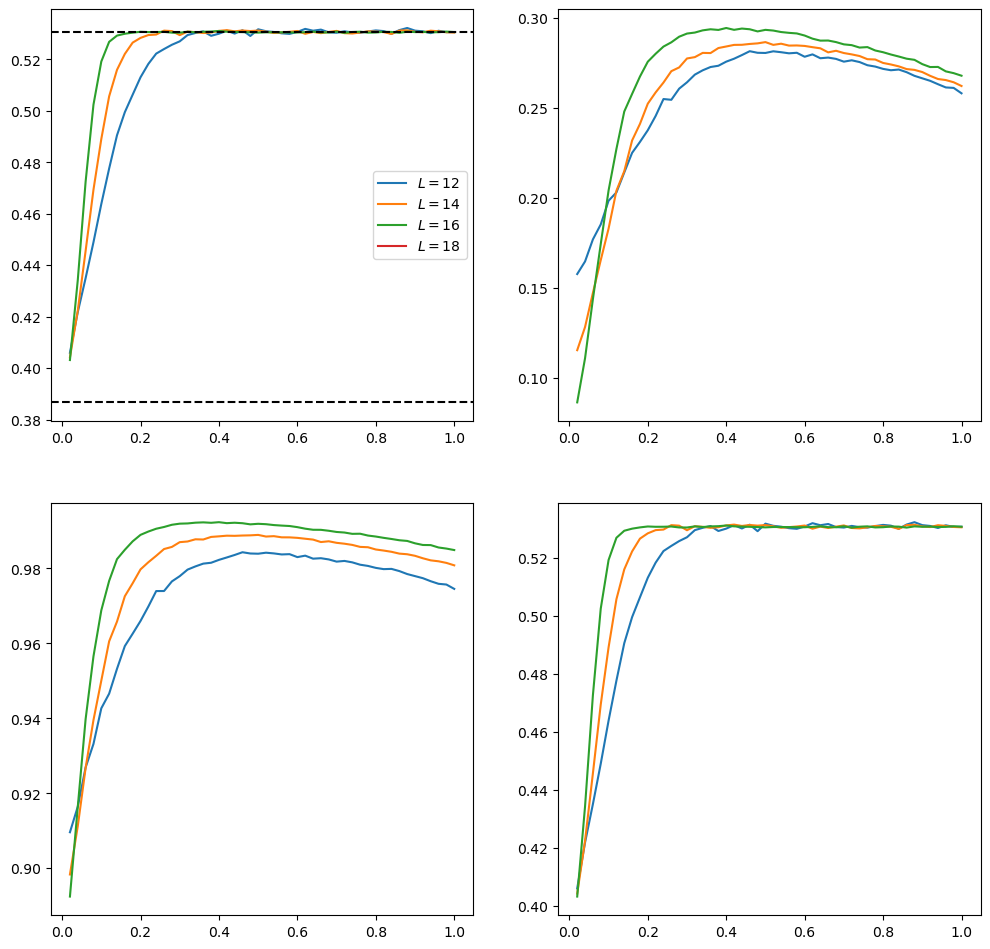

In [2]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(12,12), dpi = 100)

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class.set_scales(xscale='log', yscale='log')
settings = getattr(new_set_class, 'settings')

param_copy = copy.deepcopy(cf.params_arr)
vals = spec_fun.get_scaling_array(settings)
for x in vals:
    cf.params_arr[settings['scaling_idx']] = x
    filename = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat" 
    if exists(filename):
        stats = pd.read_table(filename, sep="\t", header=None)
        
        xdata = np.array(list(stats[0])[1:]).astype(float)
        gap_ratio = np.array(list(stats[1])[1:]).astype(float)
        ipr = np.array(list(stats[2])[1:]).astype(float)
        info_entropy = np.array(list(stats[3])[1:]).astype(float)
        
        ax1.plot(xdata, gap_ratio, label=hfun.key_title(x, settings))
        ax2.plot(xdata, ipr, label=hfun.key_title(x, settings))
        ax3.plot(xdata, info_entropy, label=hfun.key_title(x, settings))
        ax4.plot(xdata, gap_ratio, label=hfun.key_title(x, settings))

ax1.axhline(y=0.5307, ls='--', color='black')
ax1.axhline(y=0.3867, ls='--', color='black')
ax1.legend()
 #--- reset defaults
cf.params_arr = param_copy

# PLOT SPECTRAL FUNCTIONS

In [3]:
# SET LEGEND FUNCTION

from matplotlib.lines import Line2D
def add_legend(axis):
    legend = axis.legend()
    #ax = legend.axes

    handles, labels = axis.get_legend_handles_labels()
    if user_settings['scaling'] == 'k':
        new_lab = []
        for label in labels:
            label = list(label)
            label[1] = 'q'
            new_lab.append("".join(label))
        labels = new_lab
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black'));   labels.append(r"$\omega_H$")
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black', markerfacecolor='None'));   labels.append(r"$\omega^{typ}_H$")
    #handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='s', color='black'));   labels.append(r"$\omega_{Th}$")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
    axis.legend(handles, labels, frameon=False, loc='best', fontsize=10)




use_derivative = 0
time_dir = cf.base_directory + "timeEvolution%s"%kPSep
int_dir = cf.base_directory + "IntegratedResponseFunction%s"%kPSep
spec_dir = cf.base_directory + ("IntegratedResponseFunction%sDERIVATIVE%s"%(kPSep,kPSep) if use_derivative else "ResponseFunction%s"%kPSep)

agp_dir = cf.base_directory + "AGP{kPSep}" + cf.op_name + kPSep;



[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[12 14 16 18]


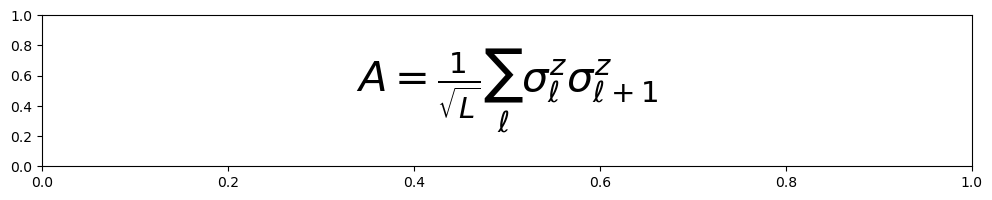

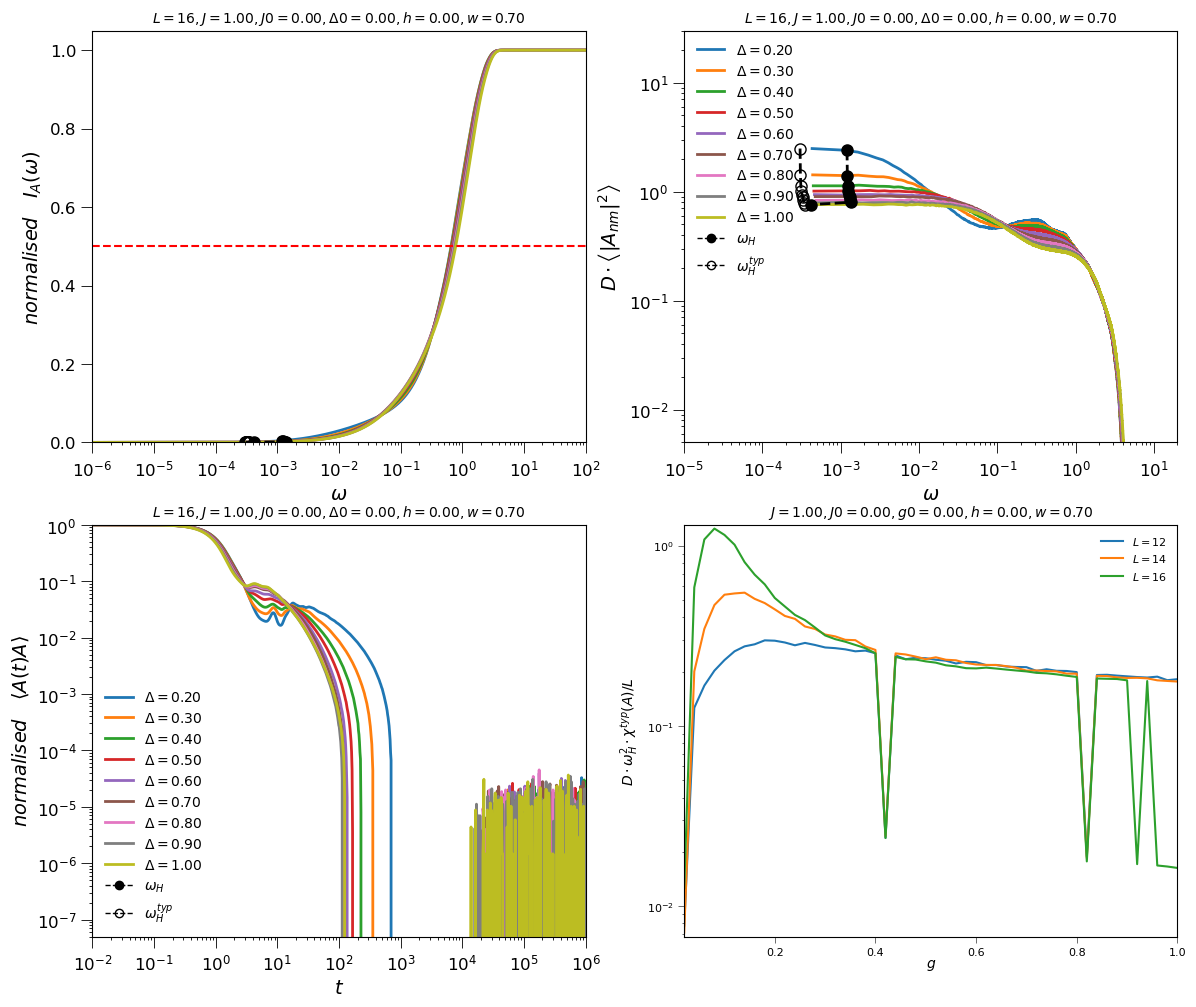

In [4]:

x0 = 0.2
xend = 1.0
dx = 0.1
vals = spec_fun.get_scaling_array(user_settings, x0, xend, dx)
print(vals)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,2), dpi = 100)
axis.annotate(r"$A=$"+cf.operator_formuals[user_settings['operator']], xy=(0.5, 0.5), color='black', size=30, ha='center', va='center')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(14,12), dpi = 100)
func_t = lambda y, x: y #* x**2
func_w = lambda y, x: y #/ x**2

#---------------------- TIME EVOLUTION
spec_fun.plot_spectral(axis = ax3, settings=user_settings, vals = vals,
                        xlab="t", ylab="\\langle A(t)A\\rangle", 
                        xscale='log',yscale='log', normalise=True, 
                        spec="time", func_x=func_t)
add_legend(axis=ax3)
ax3.set_ylim(-0.1,1)
#ax3.set_xlim(0,2e2)
#---------------------- INTEGRATED SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax1, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="I_A(\\omega)", 
                        yscale='linear', normalise=True, 
                        spec="int", func_x=func_w)
#add_legend(axis=ax1)
ax1.axhline(y=0.5, ls='--', color='red')
#ax1.legend(title=r"$A=H_{q=1}$")
ax1.set_ylim(0,1.05)

#---------------------- SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax2, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative)
if use_derivative: ax2.set_ylim(5e-30, 1e3)
else: ax2.set_ylim(5e-3, 3e1)
ax2.set_xlim(1e-5, 2e1)
add_legend(axis=ax2)
xval=np.logspace(-6,1,100)
#ax2.plot(xval, 0.38+2*xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval, linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval**2, linestyle='--', color='red')



#---------------------- ADIABATICS
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class._settings['site'] = -1
new_set_class.set_scales(xscale='linear', yscale='log')
agp.plot_agp(axis = ax4, settings_class=new_set_class, which=2)
#ax4.set_ylim(1e-2, 1e1)


[0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28 0.3
 0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58
 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86
 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
[16, 1.0, 0.55, 0.0, 0.7, 0, 1, 1, 0.0, 0.0]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0]


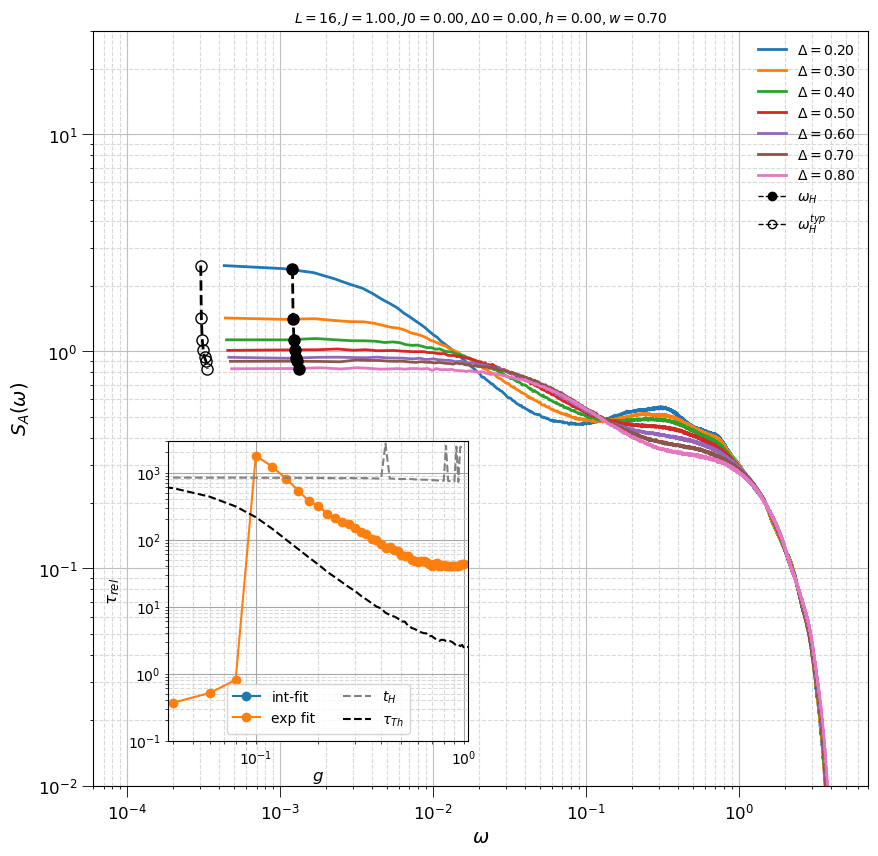

In [5]:

from cmath import nan


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)
func = lambda y, x: y #* x**1.33

vals = spec_fun.get_scaling_array(user_settings, 0.2, 0.9, 0.1)

spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals, 
                        xlab="\\omega", ylab="S_A(\\omega)", yscale='log', xscale='log', 
                        normalise=False, spec="spec", func_x=func, 
                        use_derivative=use_derivative)
axis.set_ylim(1e-2, 3e1)
axis.set_xlim(6e-5, 7e0)
#add_legend(axis=axis)
#axis.axhline(y=0.5, ls='--', color='red')
#leg = axis.legend(title=r"$A=J^s_{cur}$", fontsize=18, loc='lower right')
#leg.get_title().set_fontsize('18')
#axis.title.set_text("")


# Thouless energy

left, bottom, width, height = [0.2, 0.17, 0.3, 0.3]
axis2 = fig.add_axes([left, bottom, width, height])
vals = spec_fun.get_scaling_array(settings=user_settings, 
                                    x0=0.04, 
                                    xend=1.0, 
                                    dx=0.02)
print(vals)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(user_settings['scaling'])
new_set_class.set_scaling('L')
#cf.set_params(_w=0.3)
tau_data = []
status = False
try :
    tau_data = thouless.load(getattr(new_set_class, 'settings'))
    status = True
except OSError:
    print("No Thouless data present")
x_for_tau = []
taus = []
if status:    
    idx = list(tau_data[0]).index(cf.L)
    x_for_tau = tau_data[1][idx]
    taus = tau_data[2][idx]
relax_time = []

def xover_from_below(input_array, cut):
    x = input_array < cut
    return x.argmax() if x.any() else -1

def xover_from_above(input_array, cut):
    x = input_array > cut
    return x.argmin() if x.any() else -1

def exp_fit(x, mu, a):
    return a * np.exp(- x / mu)
def lin_fit(x, mu, a):
    return -x / mu + a

spec_at_relax = []; relaxt_time_fit = [];   tH = [];    tH_typ = [];
print(cf.params_arr)

for i in range(0, len(vals)):
    x = vals[i]
    status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=int_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="int",
                                                                    normalise=True
                                                                    )
    if status:
        idx = xover_from_below(ydata, 0.5)
        relax_time.append(1. / xdata[idx])
        tH.append(1. / wHnow)
        tH_typ.append(1. / wHtypnow)
    else:
        relax_time.append(nan)
        tH.append(nan)
        tH_typ.append(nan)

    status2, xdata2, ydata2, wHnow, wHtypnow = spec_fun.load_spectral(dir=time_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="time",
                                                                    normalise=True
                                                                    )

    if status2:
        idx_zero = xover_from_above(ydata2, 0)
        ydata2 = np.log10((ydata2))
        

        ydata2 = ydata2[:idx_zero]
        xdata2 = xdata2[:idx_zero]
        
        xfull = xdata2
        xdata2 = np.array([xdata2[i] for i in range(0,len(xdata2)) if (ydata2[i] < -1.8)])
        
        ydata2 = np.array([ydata2[i] for i in range(0,len(ydata2)) if (ydata2[i] < -1.8)])
        #print(pars)
        
        pars, sth = fit(f=lin_fit, 
                            xdata=xdata2, 
                            ydata=ydata2)
        relaxt_time_fit.append(pars[0])
    else:
        relaxt_time_fit.append(nan)
    
print(relax_time)

#relax_time = np.array(relax_time)
#axis.plot(1./relax_time, spec_at_relax);
trueQ = 2 * vals / cf.L if user_settings['scaling_idx'] == 5 else vals
xlab = "q/\\pi" if user_settings['scaling_idx'] == 5 else user_settings['scaling']


axis2.plot(trueQ, relax_time, marker='o', label='int-fit')
axis2.plot(trueQ, relaxt_time_fit, marker='o', label='exp fit')
axis2.plot(trueQ, tH, linestyle='--', label=r"$t_H$", color='gray')
#axis2.plot(trueQ, tH_typ, linestyle=':', label=r"$t_H^{typ}$", color='gray')

#axis2.plot(trueQ, 1.5e0/trueQ**1, linestyle='--', color='red', label=r"$w^{-1}$")
#axis2.plot(trueQ, 4e1/trueQ**1.66, linestyle='--', color='black', label=r"$w^{-1.66}$")

if status and user_settings['scaling_idx'] == 5: 
    axis2.axhline(y=taus[0], ls='--', color='black')
    axis2.annotate("$\it{Thouless}\ \it{Time}$", xy=(0.3,1.5e3), color='black', size=12)
else: 
    if status == False or cf.model == 2: print('No data')
    else: axis2.plot(x_for_tau, taus, linestyle='--', color='black', label=r"$\tau_{Th}$")

hfun.set_plot_elements(axis = axis2, xlim = (0.95*min(trueQ), 1.05*max(trueQ)), 
                                    ylim = (1e-1, 3e3),ylabel = "\\tau_{rel}", xlabel = xlab, settings=getattr(new_set_class, 'settings'), font_size=10, set_legend=True)
  
axis2.set_yscale('log')
axis2.set_xscale('log')
axis2.tick_params(axis='both', which='both',length=2)
axis2.grid(b=True, which='major', color='0.65', linestyle='-')
axis2.grid(b=True, which='minor', color='0.85', linestyle='--')

axis.grid(b=True, which='major', color='0.75', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')
add_legend(axis)
axis2.legend(ncol=2, loc='lower center')
#axis2.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
#def format_func(value, tick_number):
#    return "%.1f"%value
#def format_func2(value, tick_number):
#    return "%d"%value
#axis2.xaxis.set_minor_formatter(plt.FuncFormatter(format_func))
#axis2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
#axis2.yaxis.set_major_formatter(plt.FuncFormatter(format_func2))

#for line in axis.lines:
#    spec_x = line.get_xdata()
#    spec_y = line.get_ydata()
#    idx = min(range(len(spec_x)), key=lambda i: abs(spec_x[i] - 1./xdata[idx]))
#    spec_at_relax.append(spec_y[idx])


#### SHOW FIT AND RELAX TIME PLOT

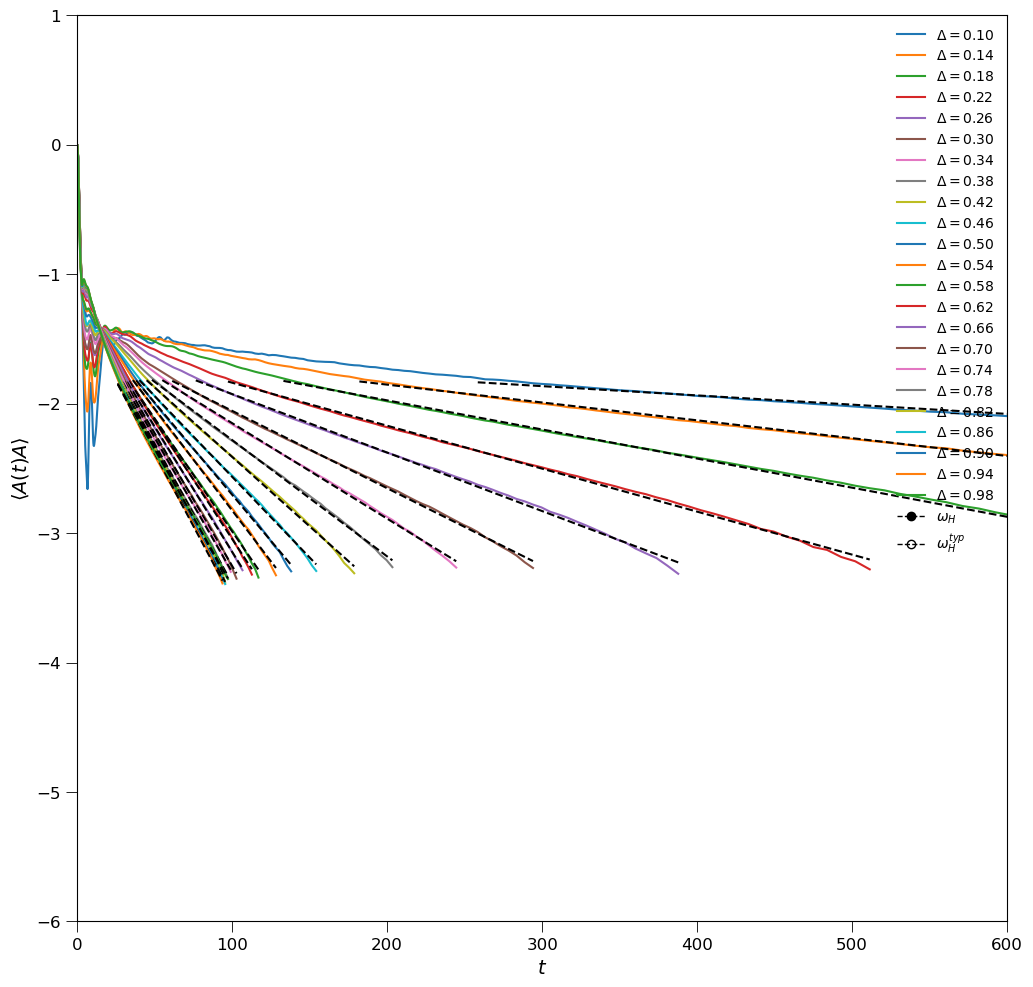

In [6]:


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,12), dpi = 100)

func = lambda y, x: y * x**1.33

xxx = 0.1

vals = spec_fun.get_scaling_array(settings=user_settings, 
                                    x0=xxx, 
                                    xend=0.9+xxx, 
                                    dx=0.04)
#---------------------- TIME EVOLUTION
#spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals,
#                        xlab="t", ylab="\\langle A(t)A\\rangle", 
#                        yscale='linear', normalise=True, 
#                        spec="time", func_x=func)


relaxt_time_fit = []
tH = []
tH_typ = []
for i in range(0, len(vals)):
    x = vals[i]
    status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=time_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="time",
                                                                    normalise=True
                                                                    )
    if status:
        idx_zero = xover_from_above(ydata, 0)
        ydata = np.log10((ydata))

        ydata = ydata[:idx_zero - 10]
        xdata = xdata[:idx_zero - 10]
        axis.plot(xdata, ydata, label=hfun.key_title(x, user_settings))
        xfull = xdata
        
        xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (ydata[i] < -1.8 and xdata[i] > 20)])
        ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (ydata[i] < -1.8 and xfull[i] > 20)])
        #print(pars)
        tH.append(wHnow)
        tH_typ.append(wHtypnow)
        pars, sth = fit(f=lin_fit, 
                            xdata=xdata, 
                            ydata=ydata)
        
        relaxt_time_fit.append(pars[0])
        axis.plot(xdata, lin_fit(xdata, *pars), linestyle='--', color='black')
#
hfun.set_plot_elements(axis = axis, xlim = (None, None), 
                                    ylim = (None, None), ylabel = "\\langle A(t)A\\rangle", xlabel = "t", settings=settings, font_size=12, set_legend=True)
  
axis.set_xscale('linear')
axis.set_yscale('linear')
axis.set_xlim(0,6e2)
axis.set_ylim(-6,1)
add_legend(axis=axis)
#relaxt_time_fit = 1.0 / np.array(relaxt_time_fit)
tH = np.array(tH)
tH_typ = np.array(tH_typ)

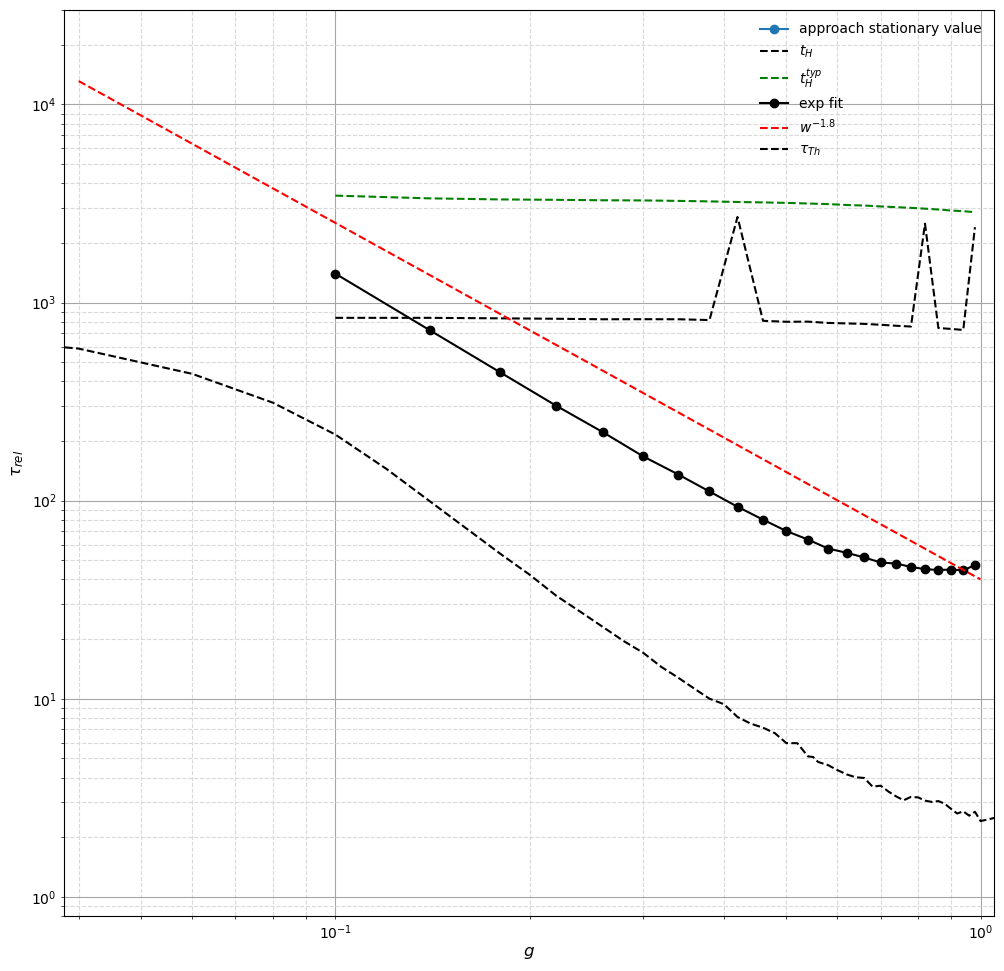

In [7]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,12), dpi = 100)

xlab = "q/\\pi" if user_settings['scaling_idx'] == 5 else user_settings['scaling']

xrescale = lambda x: x
axis.plot(xrescale(trueQ), relax_time, marker='o', label = 'approach stationary value')

axis.plot(xrescale(vals), tH, linestyle='--', color = 'black', label = r"$t_H$")
axis.plot(xrescale(vals), tH_typ, linestyle='--', color = 'green', label = r"$t_H^{typ}$")
axis.plot(xrescale(vals), relaxt_time_fit, marker='o', color = 'black', label = 'exp fit')

axis.plot(xrescale(trueQ), 4e1/trueQ**1.8, linestyle='--', color='red', label=r"$w^{-1.8}$")

if status and user_settings['scaling_idx'] == 5: 
    axis.axhline(y=taus[0], ls='--', color='black')
    axis.annotate("$\it{Thouless}\ \it{Time}$", xy=(0.3,1.5e3), color='black', size=12)
else: 
    if status == False or cf.model == 2: print('No data')
    else: axis.plot(x_for_tau, taus, linestyle='--', color='black', label=r"$\tau_{Th}$")

hfun.set_plot_elements(axis = axis, xlim = (0.95*min(xrescale(trueQ)), 1.05*max(xrescale(trueQ))), 
                                    ylim = (8e-1, 3e4),ylabel = "\\tau_{rel}", xlabel = xlab, settings=getattr(new_set_class, 'settings'), font_size=10, set_legend=True)
  
axis.set_yscale('log')
axis.set_xscale('log')
axis.tick_params(axis='both', which='both',length=2)
axis.grid(b=True, which='major', color='0.65', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')


### COMPARE FUNCTIONS

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


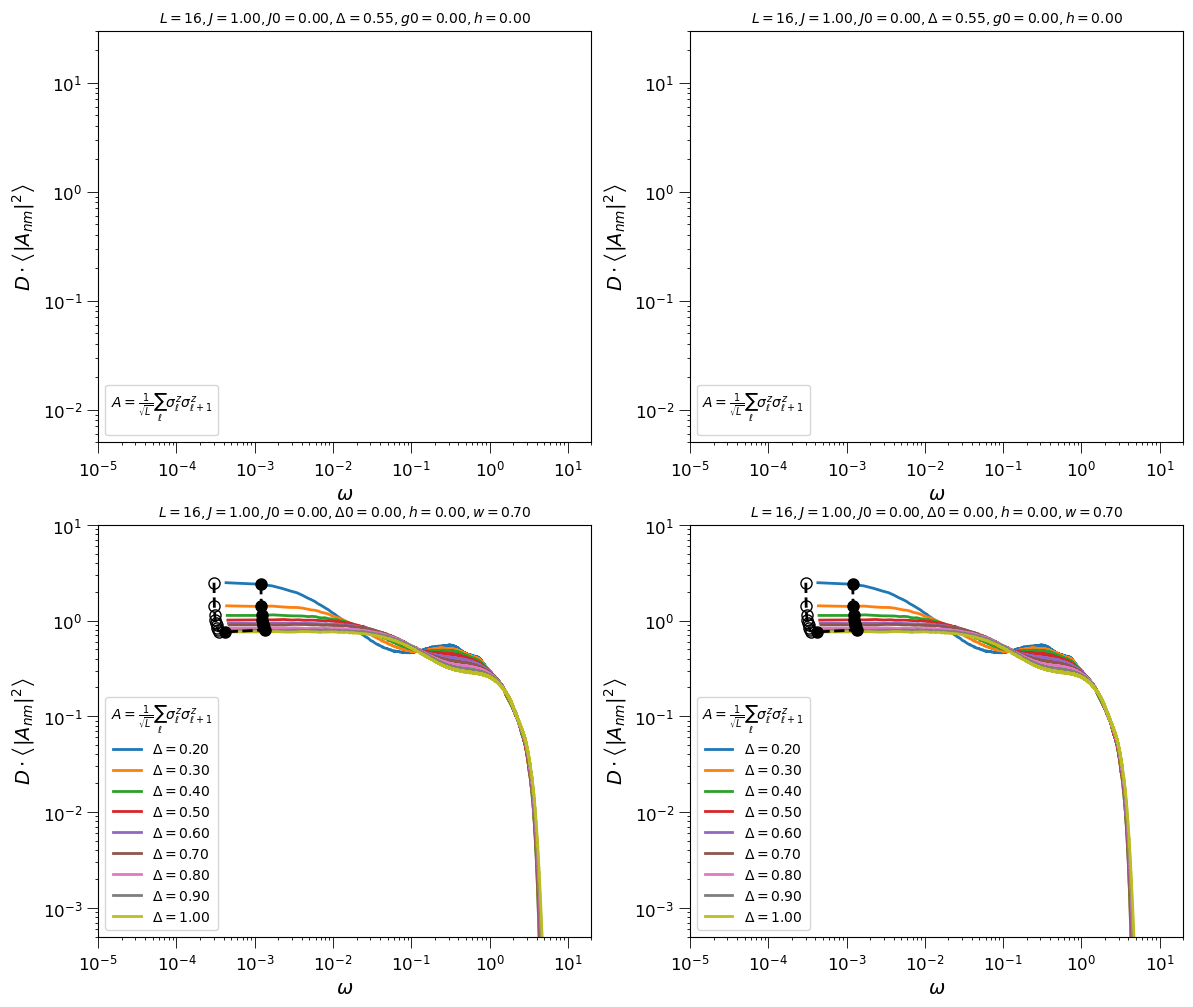

In [8]:

x0 = 0.2
xend = 1.0
dx = 0.1
vals = spec_fun.get_scaling_array(user_settings, x0, xend, dx)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(14,12), dpi = 100)

cf.set_params(_g=0.55)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scaling("w")
new_set_class._settings['operator'] = 0
new_set_class._settings['site'] = 8
settings = getattr(new_set_class, 'settings')
spec_fun.plot_spectral(axis = ax1, settings=settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative)
ax1.set_ylim(5e-3, 3e1)
ax1.set_xlim(1e-5, 2e1)
add_legend(axis=ax1)
leg = ax1.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']], loc='lower left')

new_set_class._settings['operator'] = 8
settings = getattr(new_set_class, 'settings')
spec_fun.plot_spectral(axis = ax2, settings=settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative)
ax2.set_ylim(5e-3, 3e1)
ax2.set_xlim(1e-5, 2e1)
add_legend(axis=ax2)
leg = ax2.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']], loc='lower left')

cf.set_params(_w=0.7)
new_set_class.set_scaling("g")
new_set_class._settings['operator'] = 12
settings = getattr(new_set_class, 'settings')
spec_fun.plot_spectral(axis = ax3, settings=settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative)
ax3.set_ylim(5e-4, 1e1)
ax3.set_xlim(1e-5, 2e1)
add_legend(axis=ax3)
leg = ax3.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']], loc='lower left')

new_set_class.set_scaling("g")
new_set_class._settings['operator'] = 15
settings = getattr(new_set_class, 'settings')
spec_fun.plot_spectral(axis = ax4, settings=settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative)
ax4.set_ylim(5e-4, 1e1)
ax4.set_xlim(1e-5, 2e1)
add_legend(axis=ax4)
leg = ax4.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']], loc='lower left')